# Analysis of Crime in Buffalo

* A project that strives to provide various analyses on the city’s crime-rate should greatly benefit the residents and UB students to deem areas and/or months as‘safe’ or ‘unsafe’. 
* The summary of this project should also assist the concerned departments in applying stricter laws to improve security.

In [1]:
# importing required libraries
import pandas as pd
import sqlite3
from sqlite3 import Error
import csv
csv.field_size_limit(100000000)
import matplotlib.pyplot as plt
%matplotlib inline

# Import and check info of dataset

In [2]:
# import csv dataset into dataframe
df_all = pd.read_csv("Crime_Incidents.csv")

In [3]:
# checking data summary and size
df_all.info()
df_all.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287308 entries, 0 to 287307
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Case Number              287308 non-null  object 
 1   Incident Datetime        287303 non-null  object 
 2   Incident ID              0 non-null       float64
 3   Incident Type Primary    287308 non-null  object 
 4   Incident Description     287308 non-null  object 
 5   Parent Incident Type     287308 non-null  object 
 6   Hour of Day              287308 non-null  int64  
 7   Day of Week              287308 non-null  object 
 8   Address                  287269 non-null  object 
 9   City                     287308 non-null  object 
 10  State                    287308 non-null  object 
 11  Location                 282931 non-null  object 
 12  Latitude                 282931 non-null  float64
 13  Longitude                282931 non-null  float64
 14  Crea

(287308, 29)

In [4]:
# Drop columns not needed for our analysis
df = df_all.drop(['Incident ID','updated_at','2010 Census Tract ','2010 Census Block Group','2010 Census Block',
            'Census Tract','Census Block','Census Block Group','TRACTCE20','GEOID20_tract','GEOID20_blockgroup',
            'GEOID20_block'],axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287308 entries, 0 to 287307
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Case Number            287308 non-null  object 
 1   Incident Datetime      287303 non-null  object 
 2   Incident Type Primary  287308 non-null  object 
 3   Incident Description   287308 non-null  object 
 4   Parent Incident Type   287308 non-null  object 
 5   Hour of Day            287308 non-null  int64  
 6   Day of Week            287308 non-null  object 
 7   Address                287269 non-null  object 
 8   City                   287308 non-null  object 
 9   State                  287308 non-null  object 
 10  Location               282931 non-null  object 
 11  Latitude               282931 non-null  float64
 12  Longitude              282931 non-null  float64
 13  Created At             287308 non-null  object 
 14  Neighborhood           285866 non-nu

In [6]:
# Dropping all Null rows
df[df.isna().any(axis=1)]
df = df.dropna(axis=0)

# Dropping rows which has values 
df = df[df['Neighborhood'] != 'UNKNOWN']
df = df[df['Police District'] != 'UNKNOWN']
df = df[df['Council District'] != 'UNKNOWN']

In [7]:
# checking size of our dataset to be analyzed
df.reset_index(drop = True, inplace = True)
df.shape 

(282316, 17)

# Adding data to normalized.db

In [8]:
# Function to create connection 
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

# Function to create table in db
def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
# Function to execute sql statements    
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows

# Function to insert values into table
def insert(sql,values,conn):
    cur = conn.cursor()
    cur.executemany(sql,values)

In [9]:
# Function that creates and inserts values into neighborhood table
def create_neighborhood(df_n,db_file):
    df_n = sorted(list(df_n))
    
    create_sql = """CREATE TABLE [Neighborhood] 
    ([NeighborhoodID] INTEGER PRIMARY KEY NOT NULL,
    [NeighborhoodName] TEXT NOT NULL); """
    
    sql_c = "drop table Neighborhood;"
    sql_d = "drop table Crime;"
    
    conn = create_connection(db_file,)
    create_table(conn,create_sql,"Neighborhood")
    
    insert_sql = "INSERT INTO Neighborhood(NeighborhoodName) VALUES(?)"
    
    with conn:
        values = []
        for i in df_n:
            values.append((i,))
        insert(insert_sql,values,conn)
    sql_a = "Select * from Neighborhood;"  
    df = pd.read_sql_query(sql_a,conn) 
    print(df)
    
df_neighborhood = df['Neighborhood'].unique()
db_file = 'normalized.db'

create_neighborhood(df_neighborhood,db_file)

FOREIGN KEY constraint failed
table [Neighborhood] already exists
     NeighborhoodID    NeighborhoodName
0                 1           Allentown
1                 2          Black Rock
2                 3   Broadway Fillmore
3                 4             Central
4                 5        Central Park
..              ...                 ...
100             101          South Park
101             102  University Heights
102             103     Upper West Side
103             104         West Hertel
104             105           West Side

[105 rows x 2 columns]


In [10]:
# function to create IncidentType table and insert values
def create_parentincidenttype(df_n,db_file):
    df_n = sorted(list(df_n))
    
    create_sql = """CREATE TABLE [IncidentType] 
    ([IncidentTypeID] INTEGER PRIMARY KEY NOT NULL,
    [IncidentType] TEXT NOT NULL); """
    
    conn = create_connection(db_file)
    create_table(conn,create_sql,"IncidentType")
    
    insert_sql = "INSERT INTO IncidentType(IncidentType) VALUES(?)"
    
    with conn:
        values = []
        for i in df_n:
            values.append((i,))
        insert(insert_sql,values,conn)
    sql_a = "Select * from IncidentType;"  
    df = pd.read_sql_query(sql_a,conn) 
    print(df)
 
df.loc[df['Parent Incident Type'] == 'OTHER SEXUAL OFFENSE', 'Parent Incident Type'] = 'SEXUAL OFFENSE'
df_incidenttype = df['Parent Incident Type'].unique()

create_parentincidenttype(df_incidenttype,db_file)

FOREIGN KEY constraint failed
table [IncidentType] already exists
    IncidentTypeID          IncidentType
0                1               Assault
1                2   Breaking & Entering
2                3              Homicide
3                4  Other Sexual Offense
4                5               Robbery
5                6        Sexual Assault
6                7        Sexual Offense
7                8                 Theft
8                9      Theft of Vehicle
9               10               Assault
10              11   Breaking & Entering
11              12              Homicide
12              13  Other Sexual Offense
13              14               Robbery
14              15        Sexual Assault
15              16        Sexual Offense
16              17                 Theft
17              18      Theft of Vehicle
18              19               Assault
19              20   Breaking & Entering
20              21              Homicide
21              22  Other Sexual

In [11]:
# Function that Creates table PoliceDistrict and inserts values
def create_policedistrict(df_n,db_file):
    df_n = sorted(list(df_n))
    
    create_sql = """CREATE TABLE [PoliceDistrict] 
    ([PoliceDistrictID] INTEGER PRIMARY KEY NOT NULL,
    [PoliceDistrict] TEXT NOT NULL); """
    
    conn = create_connection(db_file)
    create_table(conn,create_sql,"PoliceDistrict")
    
    insert_sql = "INSERT INTO PoliceDistrict(PoliceDistrict) VALUES(?)"
    
    with conn:
        values = []
        for i in df_n:
            values.append((i,))
        insert(insert_sql,values,conn)
    sql_a = "Select * from PoliceDistrict;"  
    df = pd.read_sql_query(sql_a,conn) 
    print(df)
 
df_n = df['Police District'].unique()

create_policedistrict(df_n,db_file)

FOREIGN KEY constraint failed
table [PoliceDistrict] already exists
    PoliceDistrictID PoliceDistrict
0                  1     District A
1                  2     District B
2                  3     District C
3                  4     District D
4                  5     District E
5                  6     District A
6                  7     District B
7                  8     District C
8                  9     District D
9                 10     District E
10                11     District A
11                12     District B
12                13     District C
13                14     District D
14                15     District E


In [12]:
# Function that Creates table councilDistrict and inserts values
def create_councildistrict(df_n,db_file):
    df_n = sorted(list(df_n))
    
    create_sql = """CREATE TABLE [CouncilDistrict] 
    ([CouncilDistrictID] INTEGER PRIMARY KEY NOT NULL,
    [CouncilDistrict] TEXT NOT NULL); """
    
    conn = create_connection(db_file)
    create_table(conn,create_sql,"CouncilDistrict")
    
    insert_sql = "INSERT INTO CouncilDistrict(CouncilDistrict) VALUES(?)"
    
    with conn:
        values = []
        for i in df_n:
            values.append((i,))
        insert(insert_sql,values,conn)
    sql_a = "Select * from CouncilDistrict;"  
    df = pd.read_sql_query(sql_a,conn) 
    print(df)
 
df_n = df['Council District'].unique()

create_councildistrict(df_n,db_file)

FOREIGN KEY constraint failed
table [CouncilDistrict] already exists
    CouncilDistrictID CouncilDistrict
0                   1        DELAWARE
1                   2        ELLICOTT
2                   3        FILLMORE
3                   4         LOVEJOY
4                   5          MASTEN
5                   6         NIAGARA
6                   7           NORTH
7                   8           SOUTH
8                   9      UNIVERSITY
9                  10        DELAWARE
10                 11        ELLICOTT
11                 12        FILLMORE
12                 13         LOVEJOY
13                 14          MASTEN
14                 15         NIAGARA
15                 16           NORTH
16                 17           SOUTH
17                 18      UNIVERSITY
18                 19        DELAWARE
19                 20        ELLICOTT
20                 21        FILLMORE
21                 22         LOVEJOY
22                 23          MASTEN
23                 

In [13]:
# Function that Creates table Description and inserts values
def create_description(df_n,db_file):
    df_n = sorted(list(df_n))
    
    create_sql = """CREATE TABLE [Description] 
    ([DescriptionID] INTEGER PRIMARY KEY NOT NULL,
    [Description] TEXT NOT NULL); """
    
    conn = create_connection(db_file)
    create_table(conn,create_sql,"Description")
    
    insert_sql = "INSERT INTO Description(Description) VALUES(?)"
    
    with conn:
        values = []
        for i in df_n:
            values.append((i,))
        insert(insert_sql,values,conn)
    sql_a = "Select * from Description;"  
    df = pd.read_sql_query(sql_a,conn) 
    print(df)

    
# df.loc[df['Incident Description'] == 'Buffalo Police are investigating this report of a crime.  It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.','Incident Description'] = 'Undefined']
df.loc[df['Incident Description'] == 'Buffalo Police are investigating this report of a crime.  It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary', 'Incident Description'] = 'Undefined'

df.loc[df['Incident Description'] == 'Buffalo Police are investigating this report of a crime.  It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.','Incident Description'] = 'Undefined'

df_n = df['Incident Description'].unique()


create_description(df_n,db_file)

FOREIGN KEY constraint failed
table [Description] already exists
    DescriptionID                                        Description
0               1                           AGG ASSAULT ON P/OFFICER
1               2                                       AGGR ASSAULT
2               3                                            ASSAULT
3               4                                           BURGLARY
4               5  Buffalo Police are investigating this report o...
5               6  Buffalo Police are investigating this report o...
6               7                            CRIM NEGLIGENT HOMICIDE
7               8                                      LARCENY/THEFT
8               9                                             MURDER
9              10                                               RAPE
10             11                                            ROBBERY
11             12                                       SEXUAL ABUSE
12             13                     

In [14]:
# Function that Creates lookup dictionary for tablename passed
def create_dictionary(tablename,db_file):
    
    ### BEGIN SOLUTION
    conn = create_connection(db_file)
    sql_z = "Select * from {};".format(tablename)
    content_list = execute_sql_statement(sql_z,conn)
    content_dict = {}
    for each_tup in content_list:
        content_dict[each_tup[1]] = each_tup[0]                   
    return content_dict
    ### END SOLUTION

In [15]:
# Function that Creates table Crime and inserts values
def create_crime(df_n,db_file):
    
    create_sql = """CREATE TABLE [Crime] 
    ([CrimeID] INTEGER PRIMARY KEY NOT NULL,
    [CaseNumber] TEXT NOT NULL,
    [IncidentDatetime] DATE,
    [IncidentTypeID] INTEGER,
    [IncidentDescriptionID] INTEGER,
    [HourofDay] INTEGER,
    [DayofWeek] TEXT,
    [CreatedAt] DATE,
    [Neighborhood] INTEGER,
    [PoliceDistrictID] INTEGER,
    [CouncilDistrictID] INTEGER,
    FOREIGN KEY(IncidentTypeID) REFERENCES IncidentType(IncidentTypeID),
    FOREIGN KEY(IncidentDescriptionID) REFERENCES Description(DescriptionID),
    FOREIGN KEY(Neighborhood) REFERENCES Neighborhood(NeighborhoodID),
    FOREIGN KEY(PoliceDistrictID) REFERENCES PoliceDistrict(PoliceDistrictID)
    FOREIGN KEY(CouncilDistrictID) REFERENCES CouncilDistrict(CouncilDistrictID)); """
    
    conn = create_connection(db_file)
    create_table(conn,create_sql,"Crime")
    
    insert_sql = "INSERT INTO Crime(CaseNumber,IncidentDatetime,IncidentTypeID,IncidentDescriptionID,HourofDay,DayofWeek,\
    CreatedAt,Neighborhood,PoliceDistrictID,CouncilDistrictID) VALUES(?,?,?,?,?,?,?,?,?,?)"
    
    neighborhood_lookup = create_dictionary('Neighborhood',db_file)
    incidenttype_lookup = create_dictionary('IncidentType',db_file)
    decription_lookup = create_dictionary('Description',db_file)
    police_lookup = create_dictionary('PoliceDistrict',db_file)
    council_lookup = create_dictionary('CouncilDistrict',db_file)
    
    with conn:
        values = []
        for index,row in df_n.iterrows():
            try:
                values.append((row['Case Number'],row['Incident Datetime'],incidenttype_lookup[row['Parent Incident Type']],\
                               decription_lookup[row['Incident Description']],row['Hour of Day'],row['Day of Week'],\
                              row['Created At'],neighborhood_lookup[row['Neighborhood']],police_lookup[row['Police District']],\
                              council_lookup[row['Council District']]))
            except:
                continue
        insert(insert_sql,values,conn)
    sql_a = "Select * from Crime limit 10;"  
    df = pd.read_sql_query(sql_a,conn) 

    
cols = ['Case Number','Incident Datetime','Parent Incident Type','Incident Description','Hour of Day','Day of Week',\
        'Created At','Neighborhood','Police District','Council District']
df_n = df[cols]
create_crime(df_n,db_file)


# Fetching data from tables

In [16]:
# Create connection with normalized db
conn = sqlite3.connect('normalized.db')

In [17]:
# Function to get the count of crimes in each month
def crime_count_by_month():
    sql_statement = """
    SELECT * FROM (
        SELECT
        Month,
        COUNT(Month) AS CrimeCount
        FROM (
            SELECT
            CrimeID, IncidentDatetime,
            CASE
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '01' THEN 'January'
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '02' THEN 'February'
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '03' THEN 'March'
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '04' THEN 'April'
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '05' THEN 'May'
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '06' THEN 'June'
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '07' THEN 'July'
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '08' THEN 'August'
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '09' THEN 'September'
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '10' THEN 'October'
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '11' THEN 'November'
                WHEN SUBSTR(IncidentDatetime, 1, 2) = '12' THEN 'December'
            END AS Month
            FROM Crime
        )
        GROUP BY Month
    )
    ORDER BY CrimeCount DESC
    """

    df_count_by_month = pd.read_sql_query(sql_statement, conn)
    return df_count_by_month

print(f"\n\n================   Crime count by month   ================== \n\n{crime_count_by_month()}")




================   Crime count by month   ================== 

        Month  CrimeCount
0        July       29474
1      August       29322
2   September       26577
3     October       26159
4        June       25212
5         May       23879
6    November       23275
7    December       21972
8     January       20750
9       April       20456
10      March       18785
11   February       16455


In [18]:
# Function to get the count of crimes at each hour
def crime_count_by_hour():
    sql_statement = """
    SELECT * FROM (
        SELECT
        HourofDay,
        COUNT(HourofDay) AS CrimeCount
        FROM Crime
        GROUP BY HourofDay
    )
    ORDER BY CrimeCount DESC
    """

    crime_count_by_hour = pd.read_sql_query(sql_statement, conn)
    return crime_count_by_hour

print(f"\n\n=====================   Crime count by hour   =================== \n\n{crime_count_by_hour()}")




=====================   Crime count by hour   =================== 

    HourofDay  CrimeCount
0           0       32759
1          12       16300
2          16       13887
3          17       13873
4          20       13363
5          18       13251
6          21       13216
7          22       13175
8          15       12867
9          23       12833
10         19       11972
11         14       11850
12         11       11730
13         13       11501
14         10       11068
15          9       10669
16          1        9816
17          8        9726
18          2        8717
19          3        7567
20          7        6469
21          4        6014
22          6        5043
23          5        4650


In [19]:
# Function to get the count of crimes on days of the week
def crime_count_by_day():
    sql_statement = """
    SELECT * FROM (
        SELECT
        DayofWeek,
        COUNT(DayofWeek) AS CrimeCount
        FROM Crime
        GROUP BY DayofWeek
    )
    ORDER BY CrimeCount DESC
    """

    crime_count_by_day = pd.read_sql_query(sql_statement, conn)
    return crime_count_by_day

print(f"\n\n===================   Crime count by day   ======================= \n\n{crime_count_by_day()}")




===================   Crime count by day   ======================= 

   DayofWeek  CrimeCount
0     Friday       42333
1   Saturday       41707
2     Monday       40155
3  Wednesday       39841
4    Tuesday       39568
5   Thursday       39396
6     Sunday       39316


In [20]:
# Function to get the count of crimes in different neighborhoods
def crime_count_by_neighborhood():
    sql_statement = """
    SELECT NeighborhoodID, NeighborhoodName, CrimeCount FROM (
        SELECT
        Neighborhood,
        COUNT(Neighborhood) AS CrimeCount
        FROM Crime
        GROUP BY Neighborhood
    ) Crime
    INNER JOIN Neighborhood ON Crime.Neighborhood = Neighborhood.NeighborhoodID 
    ORDER BY CrimeCount DESC
    """

    crime_count_by_neighborhood = pd.read_sql_query(sql_statement, conn)
    return crime_count_by_neighborhood

print(f"\n\n==================   Crime count by neighborhood   ===================== \n\n{crime_count_by_neighborhood()}")




==================   Crime count by neighborhood   ===================== 

    NeighborhoodID    NeighborhoodName  CrimeCount
0               73   Broadway Fillmore       16489
1               74             Central       15222
2               89   Kensington-Bailey       14802
3               94          North Park       13824
4               83     Genesee-Moselle       12991
5               98       Schiller Park       12043
6               78     Elmwood Bidwell       11984
7               79      Elmwood Bryant       11567
8              103     Upper West Side       10883
9              102  University Heights       10738
10             105           West Side       10252
11              88            Kenfield       10135
12              97           Riverside        9364
13              90             Lovejoy        9024
14              93         Masten Park        8937
15              91     Lower West Side        7920
16              86       Hopkins-Tifft        7360
17   

In [21]:
# Function to get the count of crimes in each police district
def crime_count_by_police_district():
    sql_statement = """
    SELECT  PoliceDistrict, CrimeCount  FROM (
        SELECT
        PoliceDistrictID,
        COUNT(PoliceDistrictID) AS CrimeCount
        FROM Crime
        GROUP BY PoliceDistrictID
    ) Crime
    INNER JOIN PoliceDistrict ON Crime.PoliceDistrictID = PoliceDistrict.PoliceDistrictID 
    ORDER BY CrimeCount DESC
    """

    crime_count_by_police_district = pd.read_sql_query(sql_statement, conn)
    return crime_count_by_police_district

print(f"\n\n====================   Crime count by Polics District   ===================== \n\n{crime_count_by_police_district()}")




====================   Crime count by Polics District   ===================== 

  PoliceDistrict  CrimeCount
0     District D       66368
1     District E       66020
2     District B       64738
3     District C       52106
4     District A       33084


In [22]:
def crime_count_by_incident_type():
    sql_statement = """
    SELECT * FROM (
        SELECT
        IncidentTypeID,
        COUNT(IncidentTypeID) AS CrimeCount
        FROM Crime
        GROUP BY IncidentTypeID
    ) Crime
    INNER JOIN IncidentType ON Crime.IncidentTypeID = IncidentType.IncidentTypeID 
    ORDER BY CrimeCount DESC
    """

    df = pd.read_sql_query(sql_statement, conn)
    return df
print(f"\n\n===================   Crime count by Incident Type   ========================= \n\n{crime_count_by_incident_type()}")



===================   Crime count by Incident Type   ========================= 

   IncidentTypeID  CrimeCount  IncidentTypeID          IncidentType
0              26      123308              26                 Theft
1              19       57735              19               Assault
2              20       53305              20   Breaking & Entering
3              27       23595              27      Theft of Vehicle
4              23       18188              23               Robbery
5              24        2470              24        Sexual Assault
6              22        2221              22  Other Sexual Offense
7              21         981              21              Homicide
8              25         513              25        Sexual Offense


# Visualization

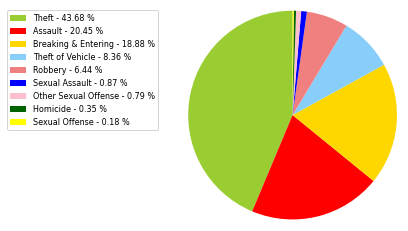

In [23]:
# incident type pie chart
incident_type_crime_count_df = crime_count_by_incident_type()

labels = incident_type_crime_count_df.loc[:, "IncidentType"]
counts = incident_type_crime_count_df.loc[:, "CrimeCount"]
    
colors = ['yellowgreen', 'red', 'gold', 'lightskyblue', 
        'lightcoral','blue','pink', 'darkgreen', 
        'yellow','grey','violet','magenta','cyan']

porcent = 100.*counts/counts.sum()

patches, texts = plt.pie(counts, colors = colors, startangle = 90, radius = 1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy = zip(*sorted(zip(patches, labels, counts), key = lambda labels: labels[2], reverse=  True))

plt.legend(patches, labels, loc = 'best', bbox_to_anchor = (-0.1, 1.), fontsize = 8)
plt.show()

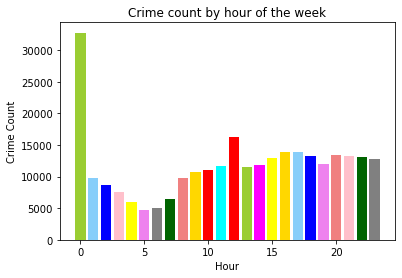

In [25]:
# Hourly Crime Count Plot
c = ['yellowgreen', 'red', 'gold', 'lightskyblue',\
     'lightcoral','blue','pink', 'darkgreen', \
          'yellow','grey','violet','magenta','cyan']
hourly_crime_count_df = crime_count_by_hour()
plt.bar(hourly_crime_count_df.loc[:, "HourofDay"], hourly_crime_count_df.loc[:, "CrimeCount"], color = c)
plt.title('Crime count by hour of the week')
plt.xlabel('Hour')
plt.ylabel('Crime Count')
plt.show()

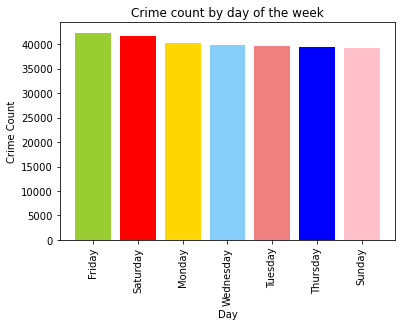

In [26]:
# Daily Crime Count Plot
daily_crime_count_df = crime_count_by_day()
plt.bar(daily_crime_count_df.loc[:, "DayofWeek"], daily_crime_count_df.loc[:, "CrimeCount"], color = c)
plt.title('Crime count by day of the week')
plt.xlabel('Day')
plt.xticks(rotation=90,fontsize = 10)
plt.ylabel('Crime Count')
plt.rc('xtick', labelsize = 5)
plt.show()

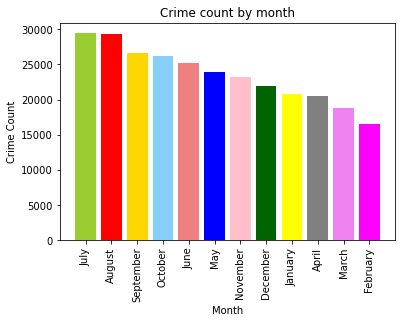

In [27]:
# Monthly Crime Count Plot
monthly_crime_count_df = crime_count_by_month()
plt.bar(monthly_crime_count_df.loc[:, "Month"], monthly_crime_count_df.loc[:, "CrimeCount"], color = c)
plt.title('Crime count by month')
plt.xlabel('Month')
plt.xticks(rotation=90,fontsize = 10)
plt.ylabel('Crime Count')
plt.show()


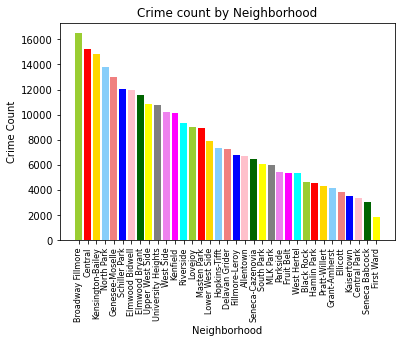

In [28]:
# Neighbourhood - Crime Count Plot
neighborhood_crime_count_df = crime_count_by_neighborhood()
plt.bar(neighborhood_crime_count_df.loc[:, "NeighborhoodName"], \
        neighborhood_crime_count_df.loc[:, "CrimeCount"], color = c)
plt.title('Crime count by Neighborhood')
plt.xlabel('Neighborhood')
plt.xticks(rotation=90,fontsize = 8)
plt.ylabel('Crime Count')
plt.show()

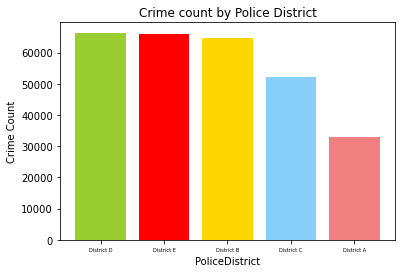

In [29]:
# Police District - Crime Count Plot
police_district_crime_count_df = crime_count_by_police_district()
plt.bar(police_district_crime_count_df.loc[:, "PoliceDistrict"],\
        police_district_crime_count_df.loc[:, "CrimeCount"], color = c)
plt.title('Crime count by Police District')
plt.xlabel('PoliceDistrict')
plt.ylabel('Crime Count')
plt.show()

# Conclusion

* The predominant crime type is Theft, followed by Assualt.
* The crime rates peaks right at midnight.
* Friday has the highest crime count in a week.
* End of Summer to the start of Fall has the highest crime count in a year.
* Broadway Fillmore, Central Terminal are the most crime prone neighborhoods.
* Seneca Babcock and First Ward are the safest areas statistilly in Buffalo.
* Police District D has the highest number of incidents reported.
